In [2]:
import os,subprocess,platform
import numpy as np

def run_DW_algo(stp_file_path):
    system = platform.system()
    if system == 'Windows':
        print("Windows/DOS based environment")
        wsl='wsl '
    elif system == 'Linux':
        print("Unix/Linux based environment")
        wsl=''
    else:
        print("Unknown operating system")
        exit(1)
    # https link to the repository
    repo=r'https://github.com/suhastheju/steiner-dreyfus-wagner/archive/master.zip'
    # path to root directory 
    root=r"./steiner-dreyfus-wagner-master"
    if not os.path.exists(root):
        try:
            subprocess.run(wsl+f'wget {repo}',shell=True,check=True)
            subprocess.run(wsl+f'unzip master.zip',shell=True,check=True)
            subprocess.run(wsl+f'rm master.zip',shell=True,check=True)
            print(f"Repository downloaded and unzipped to {root} successfully.")
        except subprocess.CalledProcessError as e:
            print("Error downloading and unzipping the repo:", e)
            exit(1)
    executable_path = root+"/reader/reader-dw"
    # Check if the executable is present in the specified directory
    if not os.path.exists(executable_path):
        print("Executable not found. Building it using make...")
        
        # Run make command in the WSL2 environment
        make_command = wsl + f"make -C {root+'/reader/'}"
        try:
            subprocess.run(make_command, shell=True, check=True)
            print("Executable built successfully.")
        except subprocess.CalledProcessError as e:
            print("Error building the executable:", e)
            exit(1)

    # Run the executable on WSL2
    command = wsl + f"{root}/reader/reader-dw -dw -in {stp_file_path} -list"
    try:
        output = subprocess.check_output(command, shell=True).decode()
        print(output)
        start_index = output.find('solution:') + len('solution:')
        end_index = output.find('command done')
        solution_str = output[start_index:end_index].strip()
        solution_list = solution_str.strip('["\']').split('", "')
        return solution_list
    except subprocess.CalledProcessError as e:
        print("Error executing reader-dw:", e)

In [3]:
import subprocess

def run_rand_pts(num_points):
    output = subprocess.check_output(f'rand-pts.exe -r {num_points}',shell=True).decode()
    points = [tuple(map(int, line.split())) for line in output.split('\n')][:-1]
    return points

def generate_hanan_grid(pins):
    hanan_grid=[]
    node_list=[None]
    terminals=[]
    tx,ty=list(zip(*pins))
    tx=list(tx)
    ty=list(ty)
    tx.sort(),ty.sort(reverse=1)
    n=len(pins)
    for i in range(n):
        for j in range(n):
            node=(tx[j],ty[i])
            node_list.append(node)
            if node in pins:terminals.append(n*i+j+1)
            if j+1<n:hanan_grid.append((n*i+j+1,n*i+j+2,tx[j+1]-tx[j]))
            if i+1<n:hanan_grid.append((n*i+j+1,n*i+j+n+1,ty[i]-ty[i+1]))

    return {'edge_list':hanan_grid,'node_list':node_list,'terminals':terminals}
# Example usage
pins= [(1,1),(2,3),(6,4)]
print(pins)
generate_hanan_grid(pins)

[(1, 1), (2, 3), (6, 4)]


{'edge_list': [(1, 2, 1),
  (1, 4, 1),
  (2, 3, 4),
  (2, 5, 1),
  (3, 6, 1),
  (4, 5, 1),
  (4, 7, 2),
  (5, 6, 4),
  (5, 8, 2),
  (6, 9, 2),
  (7, 8, 1),
  (8, 9, 4)],
 'node_list': [None,
  (1, 4),
  (2, 4),
  (6, 4),
  (1, 3),
  (2, 3),
  (6, 3),
  (1, 1),
  (2, 1),
  (6, 1)],
 'terminals': [3, 5, 7]}

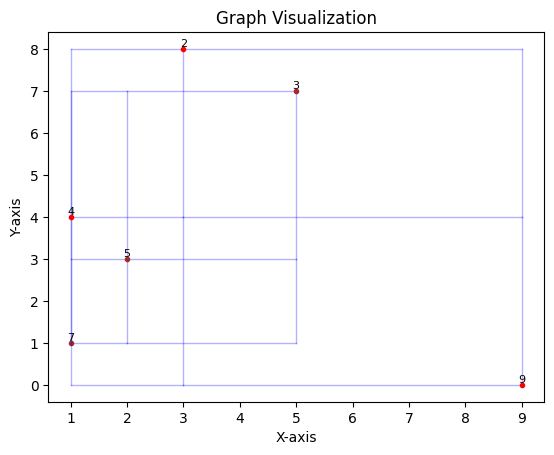

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize_hanan_grid(hanan_grid,solution_list=None,sol_graph=None,margin=100,ax=None,col='red',lwd=1.2,grid=1):
    if ax==None:
        # Create a new figure and axes
        fig, ax = plt.subplots()

    # Plot the edges
    if grid:
        for u,v,w in hanan_grid['edge_list']:
            x1, y1 = hanan_grid['node_list'][u]
            x2, y2 = hanan_grid['node_list'][v]
            ax.plot([x1, x2], [y1, y2], 'b-', linewidth=1,alpha=0.3)  # 'b-' for blue lines

    # Plot the nodes
    for t in hanan_grid['terminals']:
        ax.plot(hanan_grid['node_list'][t][0],hanan_grid['node_list'][t][1],color=col,marker='o',markersize=3)  # 'ro' for red circles

    if sol_graph is not None:
        for u,v in sol_graph['edges']:
            x1,y1 = sol_graph['nodes'][u]
            x2,y2 = sol_graph['nodes'][v]
            ax.plot([x1,x2,x2], [y1,y1,y2],color=col,linestyle='-',linewidth=lwd,alpha=0.7)  # 'r-' for red lines
        for t in sol_graph['terminals']:    
            ax.text(sol_graph['nodes'][t][0],sol_graph['nodes'][t][1],f'{t}',ha='center',va='bottom',fontsize=8)

    else:
        for t in hanan_grid['terminals']:
            ax.text(hanan_grid['node_list'][t][0],hanan_grid['node_list'][t][1],f'{t}',ha='center',va='bottom',fontsize=8)
        
    if solution_list is not None:
        solution_edges = [(int(edge.split()[0]),int(edge.split()[1])) for edge in solution_list]
        solution_nodes = list(set([node for tpl in solution_edges for node in tpl]))
        for u,v in solution_edges:
            x1, y1 = hanan_grid['node_list'][u]
            x2, y2 = hanan_grid['node_list'][v]
            ax.plot([x1,x2], [y1, y2],color=col,linestyle='-', linewidth=lwd,alpha=0.7)  # 'r-' for red lines
            
    # Set the plot title and labels
    ax.set_title('Graph Visualization')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

    # Show the plot
    # plt.show()
    return ax
fig,ax= plt.subplots()
visualize_hanan_grid(generate_hanan_grid([(1,1),(2,3),(5,7)]),ax=ax,col='brown')
visualize_hanan_grid(generate_hanan_grid([(3,8),(9,0),(1,4)]),ax=ax,col='red')
plt.show()

In [5]:
def convert_to_dimacs_stp(graph_data,stp_file):
    # Create an empty DIMACS STP string
    dimacs_stp =f"""33d32945 stp file, stp format version 1.0

section comment
name    "{stp_file}"
creator "mrinmoy banik"
remark  "sparse graph with random weights"
end

"""

    # Get the number of nodes and edges
    num_nodes = len(graph_data['node_list'])-1
    num_edges = len(graph_data['edge_list'])
    num_pins = len(graph_data['terminals'])

    dimacs_stp += f"section graph\n"
    dimacs_stp += f"nodes {num_nodes}\n"
    dimacs_stp += f"edges {num_edges}\n"

    # Add the node coordinates to the DIMACS STP string
    for u,v,w in graph_data['edge_list']:
        dimacs_stp += f"e {u} {v} {w}\n"
    dimacs_stp += "end\n\n"

    dimacs_stp += f"section terminals\n"
    dimacs_stp += f"terminals {num_pins}\n"
    for t in graph_data['terminals']:
        dimacs_stp += f"t {t}\n"
    # Add the end of section line to the DIMACS STP string
    dimacs_stp += "end\n\neof"

    with open(stp_file+'.stp','wb') as file:
        file.write(bytes(dimacs_stp,'utf-8'))
    
def checker(graph,sol):
   E1=set()
   for u,v,w in graph['edges']:
      E1.add(f'{u} {v}')
      E1.add(f'{v} {u}')
   E2=set(sol)
   if len(E2-E1):print(f'Error Solution graph has {len(E2-E1)} new edges out of {len(E2)} edges!!')
   return E2-E1

hanan_grid=generate_hanan_grid(pins)
convert_to_dimacs_stp(hanan_grid,'m05')

In [6]:
# %matplotlib qt
import networkx as nx, matplotlib.pyplot as plt
def parse_stp_file(filename):
    graph_data = {'nodes': 0, 'edges': [], 'terminals': []}
    with open(filename, 'r') as file:
        section = None
        for line in file:
            line = line.strip()
            if line.startswith('section'):
                section = line.split()[1]
            elif line == 'end':
                section = None
            elif section == 'graph':
                if line.startswith('nodes'):
                    graph_data['nodes'] = int(line.split()[1])
                elif line.startswith('edges'):
                    num_edges=int(line.split()[1])
                elif line.startswith('e'):
                    edge_data = line.split()[1:]
                    if len(edge_data) == 3:
                        source_node = int(edge_data[0])
                        target_node = int(edge_data[1])
                        weight = int(edge_data[2])
                        graph_data['edges'].append((source_node, target_node, weight))
            elif section == 'terminals':
                if line.startswith('terminals'):
                    num_terminals = int(line.split()[1])
                elif line.startswith('t'):
                    terminal_node = int(line.split()[1])
                    graph_data['terminals'].append(terminal_node)
    return graph_data

def visualize_graph(graph_data, solution_list,node_size=100):
    graph = nx.Graph()
    # Add nodes
    graph.add_nodes_from(range(1, graph_data['nodes']+1))
    # Add edges with weights
    graph.add_weighted_edges_from(graph_data['edges'])
    # Create a layout for the graph
    # pos = nx.spring_layout(graph)
    pos = nx.fruchterman_reingold_layout(graph)
    # pos = nx.kamada_kawai_layout(graph)
    # pos = nx.spectral_layout(graph)
    
    # Convert solution_list to tuples of integers
    solution_edges = [(int(edge.split()[0]), int(edge.split()[1])) for edge in solution_list]
    solution_nodes = list(set([node for tpl in solution_edges for node in tpl]))
    
    # Define node colors
    node_colors = ['r' if node in graph_data['terminals'] else 'b' for node in graph.nodes()]
    
    # Draw nodes
    terminal_nodes = nx.draw_networkx_nodes(graph, pos, node_color='r', node_size=node_size, alpha=0.8, label='Terminal Nodes')
    non_terminal_nodes = nx.draw_networkx_nodes(graph, pos, nodelist=[node for node in graph.nodes() if node not in graph_data['terminals']], node_color='b', node_size=node_size, alpha=0.8, label='Non-Terminal Nodes')
    steiner_nodes = nx.draw_networkx_nodes(graph, pos, nodelist=[node for node in solution_nodes if node not in graph_data['terminals']], node_color='g', node_size=node_size, alpha=0.8, label='Steiner Nodes')
    
    # Draw non-Steiner edges
    non_steiner_edges = [edge for edge in graph.edges() if edge not in solution_edges]
    nx.draw_networkx_edges(graph, pos, edgelist=non_steiner_edges, width=1.0, alpha=0.5, edge_color='black', label='Edges')
    
    # Draw Steiner edges
    nx.draw_networkx_edges(graph, pos, edgelist=solution_edges, width=2.0, alpha=0.8, edge_color='red', label='Steiner Edges')
    
    # Draw labels
    nx.draw_networkx_labels(graph, pos, font_size=8, font_color='black')
    
    # Draw edge weights
    edge_labels = {(u, v): d['weight'] for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=6)
    
    # Set plot title and axis labels
    plt.title('Steiner Tree Graph')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    # Add legend
    plt.legend(loc='upper right', fontsize='small')
    
    # Adjust plot margins
    plt.margins(0.1, 0.1)
    
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
def wirelength(hanan_grid=None,sol_list=None,sol_graph=None):
    if sol_list is not None:
        E=[(int(edge.split()[0]),int(edge.split()[1])) for edge in sol_list]
        pos=hanan_grid['node_list']
    elif sol_graph is not None:
        E=sol_graph['edges']
        pos=sol_graph['nodes']
    l=[np.linalg.norm(np.subtract(pos[u],pos[v]),1) for u,v in E]
    w=sum(l)
    print(f'Total weight of Rectilinear Steiner Tree(L1): {w}')
    return l
# # Usage example
# pins=run_rand_pts(12)
# hanan_grid=generate_hanan_grid(pins)
# visualize_hanan_grid(hanan_grid)
# convert_to_dimacs_stp(hanan_grid,'m05')
# # stp_file_path = r'./steiner-dreyfus-wagner-master/testset/small-instances/B/b02.stp'
# stp_file_path = r'm05.stp'
# solution_list=run_DW_algo(stp_file_path)
# graph_data = parse_stp_file(stp_file_path)
# print(f"Input Graph:-\n1.Total Nodes:{graph_data['nodes']}\n2.Terminal Nodes:{len(graph_data['terminals'])}\n3.Non-Terminal Nodes:{graph_data['nodes']-len(graph_data['terminals'])}\n4.Edges:{len(graph_data['edges'])}\n")
# print(f'Hanan Grid:{hanan_grid}')
# print(f'Parsed STP Graph:{graph_data}')
# visualize_hanan_grid(hanan_grid,solution_list)
# visualize_graph(graph_data,solution_list)
# checker(graph_data,solution_list)
# wirelength(hanan_grid,solution_list)

In [7]:
def simulate(fin):
    with open(fin,'r') as file:
        lines = file.readlines()

    # Parse the file content
    index = 0
    num_test_cases = int(lines[index].strip())
    index += 1

    for _ in range(num_test_cases):
        sum_of_array = int(lines[index].strip())
        index += 1

        # Process the tuples
        pins = []
        for _ in range(sum_of_array):
            x, y = map(int, lines[index].strip().split())
            pins.append((x, y))
            index += 1

        # Process the test case
        # Here, you can perform the desired operations with the obtained data
        # print(f"Test case: sum={sum_of_array}, tuples={tuples}")
        hanan_grid=generate_hanan_grid(pins)
        visualize_hanan_grid(hanan_grid)
        convert_to_dimacs_stp(hanan_grid,f'm0{_}')
        # stp_file_path = r'./steiner-dreyfus-wagner-master/testset/small-instances/B/b02.stp'
        stp_file_path = fr'm0{_}.stp'
        solution_list=run_DW_algo(stp_file_path)
        graph_data = parse_stp_file(stp_file_path)
        print(f"Input Graph:-\n1.Total Nodes:{graph_data['nodes']}\n2.Terminal Nodes:{len(graph_data['terminals'])}\n3.Non-Terminal Nodes:{graph_data['nodes']-len(graph_data['terminals'])}\n4.Edges:{len(graph_data['edges'])}\n")
        print(f'Hanan Grid:{hanan_grid}')
        print(f'Parsed STP Graph:{graph_data}')
        visualize_hanan_grid(hanan_grid,solution_list)
        visualize_graph(graph_data,solution_list)
        checker(graph_data,solution_list)
        wirelength(hanan_grid,solution_list)
        
# simulate('in.txt')

In [8]:
def print_flutely(edge_list,t,s):
    adj_list={}
    for u,v in g:
        if u in adj_list:adj_list[u].append(v)
        else:adj_list[u]=[v]
        if v in adj_list:adj_list[v].append(u)
        else:adj_list[v]=[u]
    n=t+s
    for i in range(t):
        if len(adj_list[i])>1:
            for j in adj_list[i]:
                adj_list[j].remove(i)
                adj_list[j].append(n)
            adj_list[n]=adj_list[i]+[i]
            adj_list[i]=[n]
            n+=1
    deg=[len(adj_list[i]) for i in range(n)]
    new_list=[]
    nodes=np.argsort(deg)[:-1]
    for i in nodes:
        # print(i)
        new_list.append([i,adj_list[i][0]])
        # print('pass')
        j=adj_list[i].pop(0)
        adj_list[j].remove(i)
    new_list.append([n-1,n-1])
    return new_list
g=[[0,1],[1,2],[1,4],[4,3]]
print_flutely(g,4,1)

[[0, 5], [1, 5], [2, 5], [3, 4], [4, 5], [5, 5]]

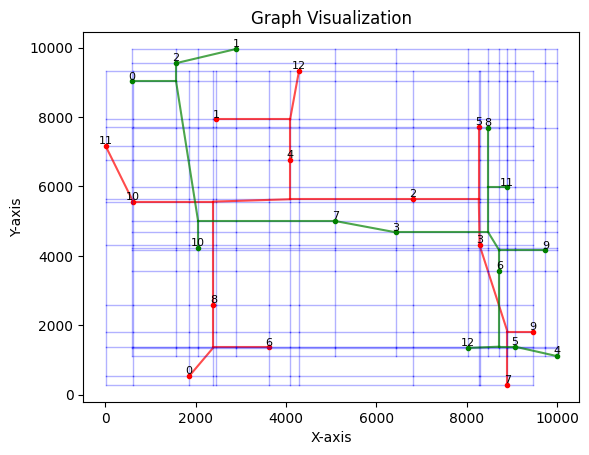

In [9]:
from ast import arg
import re
def plot_flutely(filename,hanan_grid=None,grid=1):
    args=[]
    edges=[]
    nodes=[None]
    t=0
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if line=='':
                args.append({'grid':grid,'hanan_grid':generate_hanan_grid(nodes[1:t+1]),'sol_graph':{'nodes':nodes[1:],'edges':edges,'terminals':[*range(t)]}})
                edges=[]
                nodes=[None]
                t=0
                continue
            if line[0]=='s':line=line[1:]
            else :t+=1
            u,x,y,v=map(int,line.split())
            
            edges.append((u,v))
            nodes.append((x,y))
    if len(edges)>0:args.append({'hanan_grid':generate_hanan_grid(nodes[1:t+1]),'sol_graph':{'nodes':nodes[1:],'edges':edges,'terminals':[*range(t)]}})
    return args
t=13
args1=plot_flutely(f"../Outputs/flute_out_10000_{t}-{t}.txt")
args2=plot_flutely(f"../Outputs/geosteiner_out_10000_{t}-{t}.txt")
# args3=plot_flutely(f"../geosteiner_out_10000_{t}-{t}.txt")
args4=plot_flutely(f"../Outputs/cockayne_out_10000_{t}-{t}.txt")
id=1
fig, ax = plt.subplots()
visualize_hanan_grid(**args2[0],ax=ax,col='red')
visualize_hanan_grid(**args2[1],col='green',ax=ax)
plt.show()
# visualize_hanan_grid(**args3[id])
# visualize_hanan_grid(**args4[id])
# print([wirelength(**args1[id]),wirelength(**args2[id]),wirelength(**args3[id]),wirelength(**args4[id])])
# wirelength(**args1[0])

# Multiple superimposed RSMT plotting using geosteiner:-

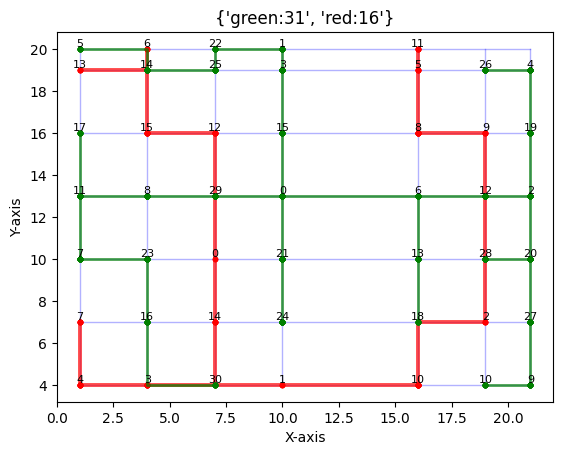

In [238]:
import random
def generate_random_with_gap(n, gap):
    if n <= 0:raise ValueError("n must be a positive integer.")
    if gap <= 0:raise ValueError("gap must be a positive integer.")
    if gap >= n:raise ValueError("gap must be less than n.")
    nums = sorted(random.sample(range(1, n * gap + 1, gap), n - 1))
    last_num = random.randint(max(nums) + 1, n * gap)
    nums.append(last_num)
    return nums
def k_equal_partition(lst, k):
    if k <= 0:
        raise ValueError("k must be a positive integer.")
    if k > len(lst):
        raise ValueError("k must be less than or equal to the length of the list.")
    partition_size = len(lst) // k
    remainder = len(lst) % k
    partitions = []
    start_index = 0
    for i in range(k):
        end_index = start_index + partition_size + (1 if i < remainder else 0)
        partitions.append(lst[start_index:end_index])
        start_index = end_index
    return partitions
def k_unequal_partition(input_list, k):
    shuffled_list = random.sample(input_list, len(input_list))
    indices = sorted(random.sample(range(1, len(input_list)), k - 1))
    partitions = []
    start_idx = 0
    for idx in indices:
        partitions.append(shuffled_list[start_idx:idx])
        start_idx = idx
    partitions.append(shuffled_list[start_idx:])
    return partitions
def coupled_points(k,n,m,gap=3):
    terminals=[]
    x=generate_random_with_gap(m,gap)
    y=generate_random_with_gap(m,gap)
    nodes=random.sample(list(range(0,m**2)),n*k)
    tx=set()
    ty=set()
    for i in range(m):
        for j in range(m):
            node=m*i+j+1
            if node in nodes:
                tx.add(x[i])
                ty.add(y[j])
                terminals.append((x[i],y[j]))
    random.shuffle(terminals)
    terms=[]
    return terminals,k_unequal_partition(terminals,k),tx,ty
def geosteiner(k,n,m=0,gap=3):
    if not m:m=n*(k-1)
    allpins,pins,x,y=coupled_points(k,n,m,gap=gap)
    l=[len(i) for i in pins]
    file='temp_in.txt'
    with open(file, 'w') as f:
        f.write(f'{k}\n')
        for i in pins:
            f.write(f'{len(i)}\n')
            for j in i:
                f.write(f'{j[0]} {j[1]}\n')
    subprocess.run(f'wsl ../geosteiner-5.3/my_demo temp_in.txt temp_out.txt temp_log.txt')
    args=plot_flutely('temp_out.txt',grid=0)
    fig, ax = plt.subplots()
    for i in x:
        ax.plot([i,i],[min(y),max(y)], 'b-', linewidth=1,alpha=0.3)  # 'b-' for blue lines
    for i in y:
        ax.plot([min(x),max(x)],[i,i],'b-', linewidth=1,alpha=0.3)  # 'b-' for blue lines
    col=['red','green','black','purple','yellow','brown','cyan','pink']
    lwd=1.2+0.8*k
    for i in range(k):
        visualize_hanan_grid(**args[i],ax=ax,col=col[i],lwd=lwd)
        lwd-=0.8
    plt.title({f'{col[i]}:{l[i]}' for i in range(k)})
    # plt.show()

geosteiner(k=2,n=24,m=7,gap=3)

In [ ]:
for i in range(75,100):
    geosteiner(k=2,n=24,m=7,gap=3)
    try:
        plt.savefig(f'Samples/2Net_{i}.png')
    except ValueError as e:
        print(f'Value error at {i}!')

# Utility function to check if geosteiner-5.3 src code uses rand keyword:-

In [11]:
import os

def find_files_with_random_h(directory):
    result = []
    words=['rand']
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".c"):
                file_path = os.path.join(root, file)
                with open(file_path, "r") as f:
                    content = f.read()
                    for w in words:
                        if w in content:result.append(file_path)
    return result

if __name__ == "__main__":
    directory_to_search = "../geosteiner-5.3/"
    files_with_random_h = find_files_with_random_h(directory_to_search)

    if files_with_random_h:
        print("The following .c files use random.h library:")
        for file_path in files_with_random_h:
            print(file_path)
    else:
        print("No .c file in the directory uses random.h library.")


The following .c files use random.h library:
../geosteiner-5.3/analyze.c
../geosteiner-5.3/constrnt.c
../geosteiner-5.3/demo2.c
../geosteiner-5.3/demo4.c
../geosteiner-5.3/egmp.c
../geosteiner-5.3/fpdebug.c
../geosteiner-5.3/localcut.c
../geosteiner-5.3/prng_aes256.c
../geosteiner-5.3/prng_legacy.c
../geosteiner-5.3/prng_new.c
../geosteiner-5.3/rand_points.c
../geosteiner-5.3/rfst.c
../geosteiner-5.3/triangle.c
../geosteiner-5.3/lp_solve_2.3\solve.c


# Modified REST/utils/rsmt_utils.py:read_data() func to read from files of the form in.txt:-

In [ ]:
import numpy as np
def read_data2(test_file):
    with open(test_file, 'r') as f:
        test_data = []
        num_testcases = int(f.readline().strip())
        for _ in range(num_testcases):
            num_points = int(f.readline().strip())
            points = []
            for _ in range(num_points):
                x, y = map(int, f.readline().strip().split())
                points.append([x/10000, y/10000])
            test_data.append(points)
    return np.array(test_data)
adj=read_data2("in.txt")

# Unfinished REST/utils/rsmt_utils.py function to print in flute format:-

In [ ]:
from functools import cmp_to_key
class point:
    def __init__(self, x, y,a):
        self.x = x
        self.y = y
        self.a = a
    
def flutely(edgelist):
    ps,pt,p=[],[],[]
    for u,v in edgelist:
        if u[2] and u not in pt:pt.append(u)
        elif not u[2] and u not in ps:ps.append(u)
        if v[2] and v not in pt:pt.append(v)
        elif not v[2] and v not in ps:ps.append(v)
    pos=[]
    p=pt+ps
    for x,y,a in p:pos.append((x,y))
    print(f'pt:{pt}')
    print(f'ps:{ps}')
    print(f'p:{p}')
    print(f'pos:{pos}')
    t,s=len(pt),len(ps)
    n=t+s
    adjList=[[] for _ in range(n)]
    for p1,p2 in edgelist:
        u,v=p.index(p1),p.index(p2)
        print(f'u:{u},v:{v}')
        adjList[u].append(v)
        adjList[v].append(u)
    print(f'adjList{adjList}')
    for i in range(t):
        if len(adjList[i])>1:
            for j in adjList[i]:
                print(j)
                adjList[j].append(n)
                if i in adjList[j]:adjList[j].remove(i)
            adjList.append(adjList[i])
            adjList[n].append(i)
            adjList[i]=[n]
            pos.append(pos[i])
            n+=1
    newList=[]
    seen=set()
    cmp=lambda l,r:(len(l)>0 and (len(r)==0 or len(l)<len(r)))
    while(adjList):
        adji=min(adjList,key=cmp_to_key(cmp))
        if not adji:break
        print(f'adji:{adji}')
        i,j=adjList.index(adji),adji[0]
        adjList[i].pop(0)
        adjList[j].remove(i)
        if i in seen:
            newList.append([j,i])
            seen.add(j)
        else :
            newList.append([i,j])
            seen.add(i)
    sorted(newList,key=lambda x:x[0])
    print(f'newList{newList}')
    for i,j in newList:
        if i<t:print(f'{i} {pos[i][0]} {pos[i][1]} {j}')
        else: print(f's{i} {pos[i][0]} {pos[i][1]} {j}')
    print(f's{n-1} {pos[n-1][0]} {pos[n-1][1]} {n-1}')
    return n-t
el=[((1,1,1),(1,2,0)),((1,2,0),(2,2,1))]
flutely(el)

pt:[(1, 1, 1), (2, 2, 1)]
ps:[(1, 2, 0)]
p:[(1, 1, 1), (2, 2, 1), (1, 2, 0)]
pos:[(1, 1), (2, 2), (1, 2)]
u:0,v:2
u:2,v:1
adjList[[2], [2], [0, 1]]
adji:[2]
newList[[0, 2]]
0 1 1 2
s2 1 2 2


1